In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os
import time

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number

# ensemble functions
import huxt_ensemble_functions as hef 
import calibration_functions as cf

In [2]:
def ICMElist(filepath = None):
    # -*- coding: utf-8 -*-
    """
    A script to read and process Ian Richardson's ICME list.

    Some pre-processing is required:
        Download the following webpage as a html file: 
            http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm
        Open in Excel, remove the year rows, delete last column (S) which is empty
        Cut out the data table only (delete header and footer)
        Save as a CSV.

    """
    
    if filepath is None:
        datapath =  system._setup_dirs_()['datapath']
        filepath = os.path.join(datapath,
                                'icmetable.csv')
    
    
    icmes=pd.read_csv(filepath,header=None)
    #delete the first row
    icmes.drop(icmes.index[0], inplace=True)
    icmes.index = range(len(icmes))
    
    for rownum in range(0,len(icmes)):
        for colnum in range(0,3):
            #convert the three date stamps
            datestr=icmes[colnum][rownum]
            year=int(datestr[:4])
            month=int(datestr[5:7])
            day=int(datestr[8:10])
            hour=int(datestr[11:13])
            minute=int(datestr[13:15])
            #icmes.set_value(rownum,colnum,datetime(year,month, day,hour,minute,0))
            icmes.at[rownum,colnum] = datetime.datetime(year,month, day,hour,minute,0)
            
        #tidy up the plasma properties
        for paramno in range(10,17):
            dv=str(icmes[paramno][rownum])
            if dv == '...' or dv == 'dg' or dv == 'nan':
                #icmes.set_value(rownum,paramno,np.nan)
                icmes.at[rownum,paramno] = np.nan
            else:
                #remove any remaining non-numeric characters
                dv=re.sub('[^0-9]','', dv)
                #icmes.set_value(rownum,paramno,float(dv))
                icmes.at[rownum,paramno] = float(dv)
        
    
    #chage teh column headings
    icmes=icmes.rename(columns = {0:'Shock_time',
                                  1:'ICME_start',
                                  2:'ICME_end',
                                  10:'dV',
                                  11: 'V_mean',
                                  12:'V_max',
                                  13:'Bmag',
                                  14:'MCflag',
                                  15:'Dst',
                                  16:'V_transit'})
    return icmes


def date_from_ensemble_folder_name(fname):
    
    """
    extracts date from wsa filename

    Args:
        fname (string) : name of ensemble file set
    Returns:
        date_string (string) : date string generated from info within file string format
        date_obj (datetime) : datetime object from file name
    """

    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, fname)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')

    return date_string, date_obj

def read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude,  year_str, start_date, end_date, gen_dist, observations):

    year_id = {'2023':'_2023', '2020':'_2020'} # awkward file string formating stuff which will be removed when I fix the file name consistency

    # get all ensemble netCDF file strings of specified parameters
    ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
    ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}_wsa{year_id[year_str]}{gen_dist}'] # keywords to filter ensemble set directory
    print(ensemble_file_words)
    ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]
    all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory
    dates = []
    filenames = []

    # creating list of filenames of ensemble files for reading in ensembles over a specfied date range
    for filename in all_files:

        #unpack ensemble datenum into an indexable datetime obj
        pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
        match = re.search(pattern, filename)
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

    # index ensemble filenames by date
    df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
    df_ens_filenames = df_ens_filenames.sort_index()

    date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

    # Finding closest indices
    indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

    # Retrieving the closest rows
    closest_files = df_ens_filenames.iloc[indexer]

    # Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
    unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

    # list of ensemble netCDF filenames within date_range
    fname_list = unique_files['file_string'].to_list()

    daily_ensemble_sets = []
    updated_data_chunks = []

    for fname in fname_list:
        date_string, date_obj = date_from_ensemble_folder_name(fname)
        random_seed = int(date_obj.strftime("%y%m%d%H%M"))

        # read in ensemble members and perturb longitudinally
        ensemble_members = hef.read_ens_cdf(date_string=date_string, sigma_latitude=sigma_latitude, ensemble_size=ensemble_size, coronal_model='wsa', year=year_str, gen_dist=gen_dist)
        lp_ens_members = hef.perturb_ensemble_longitudinally(ensemble_members=ensemble_members, sigma_longitude=sigma_longitude, 
                                                                ensemble_size=ensemble_size, random_seed=random_seed)

        observed_df = observations['V'][lp_ens_members[0].index[0]:lp_ens_members[0].index[-1]]
        resampled_ensemble_data = [hef.interpolate_and_resample(observed_data=observed_df, forecast_series=ens_mem) for ens_mem in lp_ens_members]

        resampled_ensembles_df = pd.DataFrame(np.stack(resampled_ensemble_data).T, index=observed_df.index, columns=[f'vsw_{i}' for i in range(ensemble_size)])
        resampled_ensembles_df['observation'] = observed_df

        #append to main storage list
        daily_ensemble_sets.append(resampled_ensembles_df)
        updated_data_chunks.append(observed_df)

    return daily_ensemble_sets

def read_chi_arr_by_longitude(era_key, sigma_longitude, lead_time, gen_dist):
    
    fname = f'rank_hist_{era_key}_{int(sigma_longitude)}_{lead_time}_lead{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','rank_analysis',fname))
    
    return np.genfromtxt(fname = file_path, delimiter=',')

def read_REL_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'REL_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','reliability_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_RES_by_longitude(era_key, sigma_longitude, lead_time, threshold, gen_dist):

    fname = f'RES_{era_key}_{int(sigma_longitude)}_{lead_time}_lead_{int(threshold)}{gen_dist}.csv'
    file_path = os.path.abspath(os.path.join(os.pardir,'data','resolution_scores',fname))

    return np.genfromtxt(fname = file_path, delimiter=',')

def read_rank_hist_file(era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')


def split_into_lead_time_sections(max_lead_time, daily_ensemble_sets):

    # intialise and prepare dictionary to collate forecast lead time sets
    lead_time_dict = {}
    for i in range(max_lead_time):
        lead_time_dict.update({f'{i+1}_day_lead':[]})

    for df_ in daily_ensemble_sets:

        # start time from index
        init_time = df_.index[0]
        day_dt = pd.Timedelta(days=1)

        # loop through lead times and chunk up ensembles by lead time adding to lead time dictionary
        for k in range(max_lead_time):
            lead_time_dict[f'{k+1}_day_lead'].append(df_.loc[init_time+(day_dt*k):init_time+(day_dt*(k+1))])

    return lead_time_dict


def finding_cost_loss(actual_events, forecasted_probabilities, threshold):
    """
    Finding costs and loss based on an action threshold.

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    forecasted_probabilities (array): List of forecasted probabilities for events.
    threshold (float): Threshold for action.

    Returns:
    dict: Dictionary containing counts for correct forecasts, incorrect forecasts, and missed events.
    """
    correct_forecasts = 0
    incorrect_forecasts = 0
    missed_events = 0

    for actual, probability in zip(actual_events, forecasted_probabilities):
        if actual and probability >= threshold: # correctly forecast event (incurring a cost)
            correct_forecasts += 1
        elif not actual and probability >= threshold: # incoreectly forecast event (incurring a cost)
            incorrect_forecasts += 1
        elif actual and probability < threshold: # missing an event (incurring a loss)
            missed_events += 1
    
    return {'correct_costs': correct_forecasts, 'incorrect_costs': incorrect_forecasts, 'loss': missed_events}


def calculate_potential_economic_value(actual_events, costs, losses, cost_loss_ratio):

    """
    Finding potenial economic value

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    costs (float): number of costs
    losses (float): number of losses
    cost_loss_ratio (float): cost loss ratio for computing potential economic value

    Returns:
    V: potential economic value
    """
        
    climatology_prob = np.mean(actual_events)
    #climatology_prob = 0.25
    perfect_cost = np.sum(actual_events)

    # climatological cost changes if climatological prob is above/below c/l ratio 
    if cost_loss_ratio <= climatology_prob: # always take action

        climatological_cost = len(actual_events)
        climatological_expense = climatological_cost*cost_loss_ratio
    
        #climatological_expense = len(action_threshold_data)*cost_loss_ratio

    elif cost_loss_ratio > climatology_prob: # never take action

        climatological_loss = perfect_cost
        climatological_expense = climatological_loss

    # forecast expense
    forecast_expense = costs*cost_loss_ratio + losses

    # potential economic value
    V = 100 * ((climatological_expense - forecast_expense)/(climatological_expense - perfect_cost*cost_loss_ratio))

    return V

def crps_discrete(ensemble_slice, observation):

    #print(observation)
    if np.isnan(observation) == True:
        crps_int = np.NaN
        crps_disc = np.NaN

    else:
        lower_limit = 200
        upper_limit = 850
        n_bins = upper_limit - lower_limit + 1

        bin_edges = np.linspace(lower_limit, upper_limit, n_bins)
        ensemble_hist, bin_edges = np.histogram(ensemble_slice, bins=bin_edges)

        # Compute bin widths
        bin_widths = np.diff(bin_edges)
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Convert to probability densities
        pdf = ensemble_hist / (np.sum(ensemble_hist) * bin_widths)

        # Compute CDF
        cdf = np.cumsum(ensemble_hist)  
        cdf = cdf / cdf[-1]    # Normalize to get values between 0 and 1

        # compute crps by evaluating the two halves of the cdf split by the observation
        term1_index = bin_centres <= observation
        term2_index = bin_centres > observation

        # term1 = integrate.trapezoid(cdf[term1_index]**2, bin_centres[term1_index])
        # term2 = integrate.trapezoid((cdf[term2_index]-1)**2, bin_centres[term2_index])
        # crps_int = term1 + term2

        term1_disc = np.sum((cdf[term1_index]*bin_widths[term1_index])**2)
        term2_disc = np.sum(((cdf[term2_index]-1)*bin_widths[term2_index])**2)
        crps_disc = term1_disc + term2_disc

        if crps_disc < 1e-5:
            crps_disc = np.NaN

    return crps_disc

def crps_ensemble_evaluation(daily_ensemble_sets):

    #evaluate crps for each ensemble by timestep 
    for df_ in daily_ensemble_sets:
        crps_list = np.array([crps_discrete(df_.iloc[i].filter(like='vsw'), df_.iloc[i]['observation']) for i in range(df_.shape[0])])
        df_['crps'] = crps_list # add evaluations as a column in ensemble dataframe

        #evaluate climatology and skill score for each ensemble 
        crps_climate = np.array([crps_discrete(climatology, df_.iloc[i]['observation']) for i in range(df_.shape[0])])
        df_['crps_climate'] = crps_climate # add evaluations as a column in ensemble dataframe#
        df_['crpss'] = 1 - (df_['crps']/df_['crps_climate'])

    return



In [3]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
#omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

## Create verificaton dataset with ICMEs removed from the timeseries
df_ICME = ICMElist("C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_Calibration\\data\\icmetable.csv")
df_ICME = df_ICME.set_index('Shock_time')

# Create a list of ICME (start,end) times 
CME_flags = [*zip(df_ICME.loc['2020':'2023']['ICME_start'], df_ICME.loc['2020':'2023']['ICME_end'])]

# Loop through ICME timing list and remove observations within CME start/end crossing period.
df_temp = omni_data.copy()
for start_time, end_time in CME_flags:
    
    # Replace values with NaN for rows within the specified time period
    df_temp.loc[(df_temp.index >= start_time) & (df_temp.index <= end_time)] = np.nan

    # Remove from time_series 
    #df_filtered = df_temp[~((df_temp.index >= start_time) & (df_temp.index <= end_time))]
    #df_temp = df_filtered.copy()

df_filtered = df_temp.copy()  

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


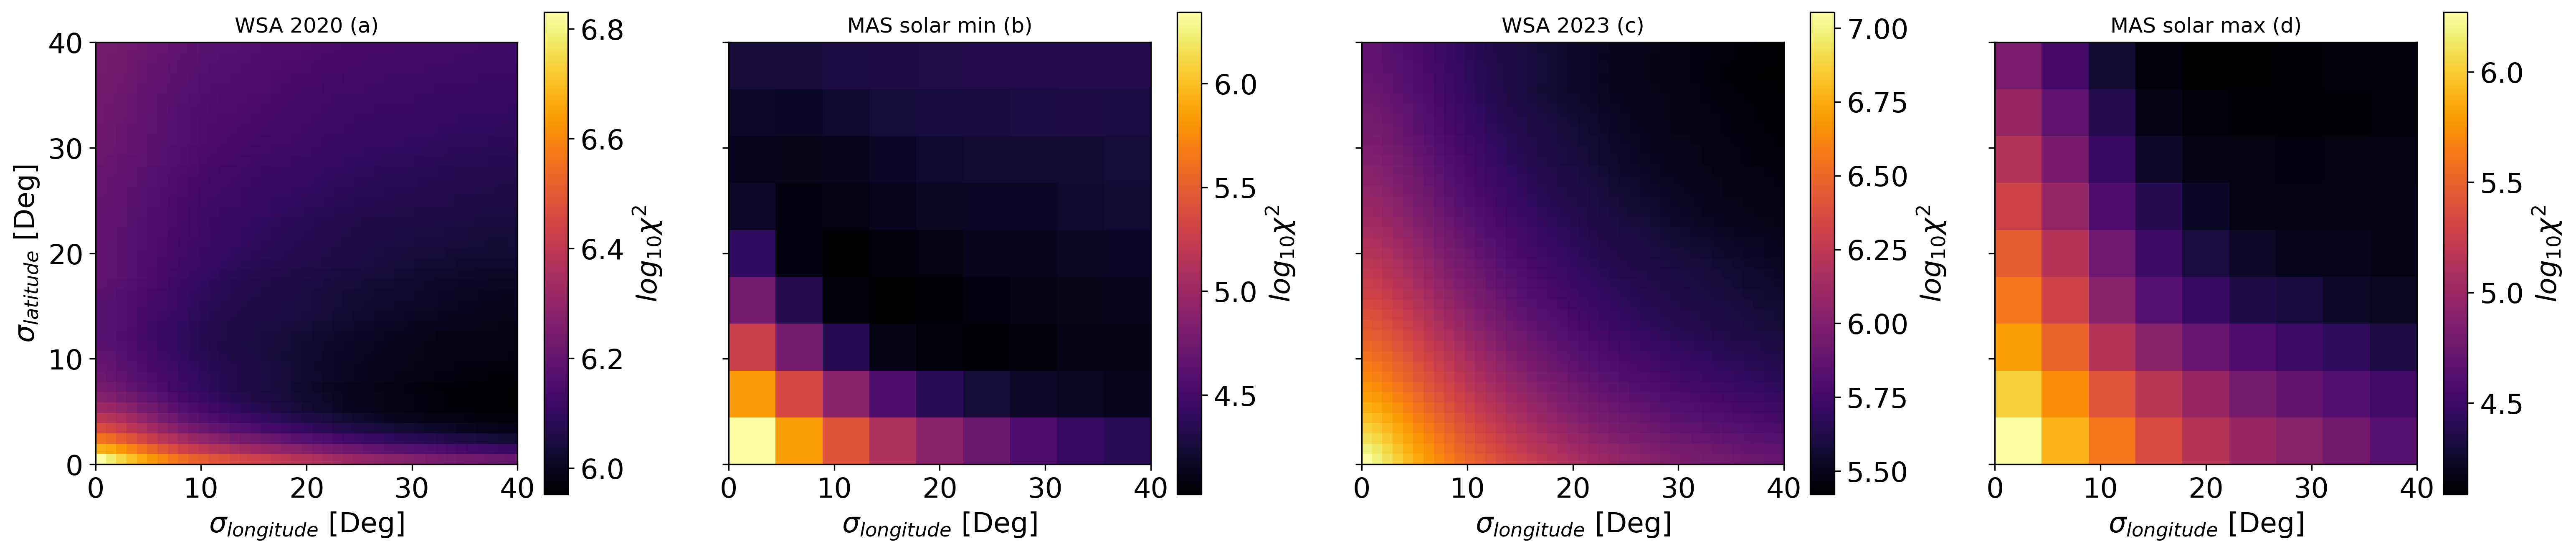

In [15]:
CR_chunk_key = ['min', 'other', 'max']
MAS_rank_histogram_grids = [read_rank_hist_file(key) for key in CR_chunk_key]

longitudes_to_test = np.linspace(0,40,41)
lead_time=123
gen_dist = '_fullrot'

chi_arr_2023 = [read_chi_arr_by_longitude(era_key='2023', sigma_longitude=lon, lead_time=lead_time, gen_dist=gen_dist) for lon in longitudes_to_test]
chi_arr_2020 = [read_chi_arr_by_longitude(era_key='2020', sigma_longitude=lon, lead_time=lead_time, gen_dist=gen_dist) for lon in longitudes_to_test]

fig, axes = plt.subplots(nrows=1, ncols=4,dpi=300,figsize=(25,5), sharey=True)

axes = axes.flatten()

im = axes[0].imshow(np.log10(chi_arr_2020).T, cmap = 'inferno', origin = 'lower', extent=[0,40,0,40])
axes[0].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
axes[0].set_title('WSA 2020 (a)')

im1 = axes[1].imshow(np.log10(MAS_rank_histogram_grids[0]), extent=[0,40,0,40], cmap = 'inferno', origin = 'lower')
axes[1].set_title('MAS solar min (b)')
axes[1].set_xlabel(r'$\sigma_{longitude}$ [Deg]')

im2 = axes[2].imshow(np.log10(chi_arr_2023).T, cmap = 'inferno', origin = 'lower', extent=[0,40,0,40])
axes[2].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
axes[2].set_title('WSA 2023 (c)')


im3 = axes[3].imshow(np.log10(MAS_rank_histogram_grids[2]), extent=[0,40,0,40], cmap = 'inferno', origin = 'lower')
axes[3].set_title('MAS solar max (d)')
axes[3].set_xlabel(r'$\sigma_{longitude}$ [Deg]')

axes[0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
#axes[2].set_ylabel(r'$\sigma_{latitude}$ [Deg]')

fig.colorbar(im, ax = axes[0], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im1, ax = axes[1], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im2, ax = axes[2], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im3, ax = axes[3], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)
filename = "rank_histogram_arrays.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"

plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')
#plt.savefig(fpath, format = 'svg', dpi = 300, bbox_inches='tight')

plt.show()


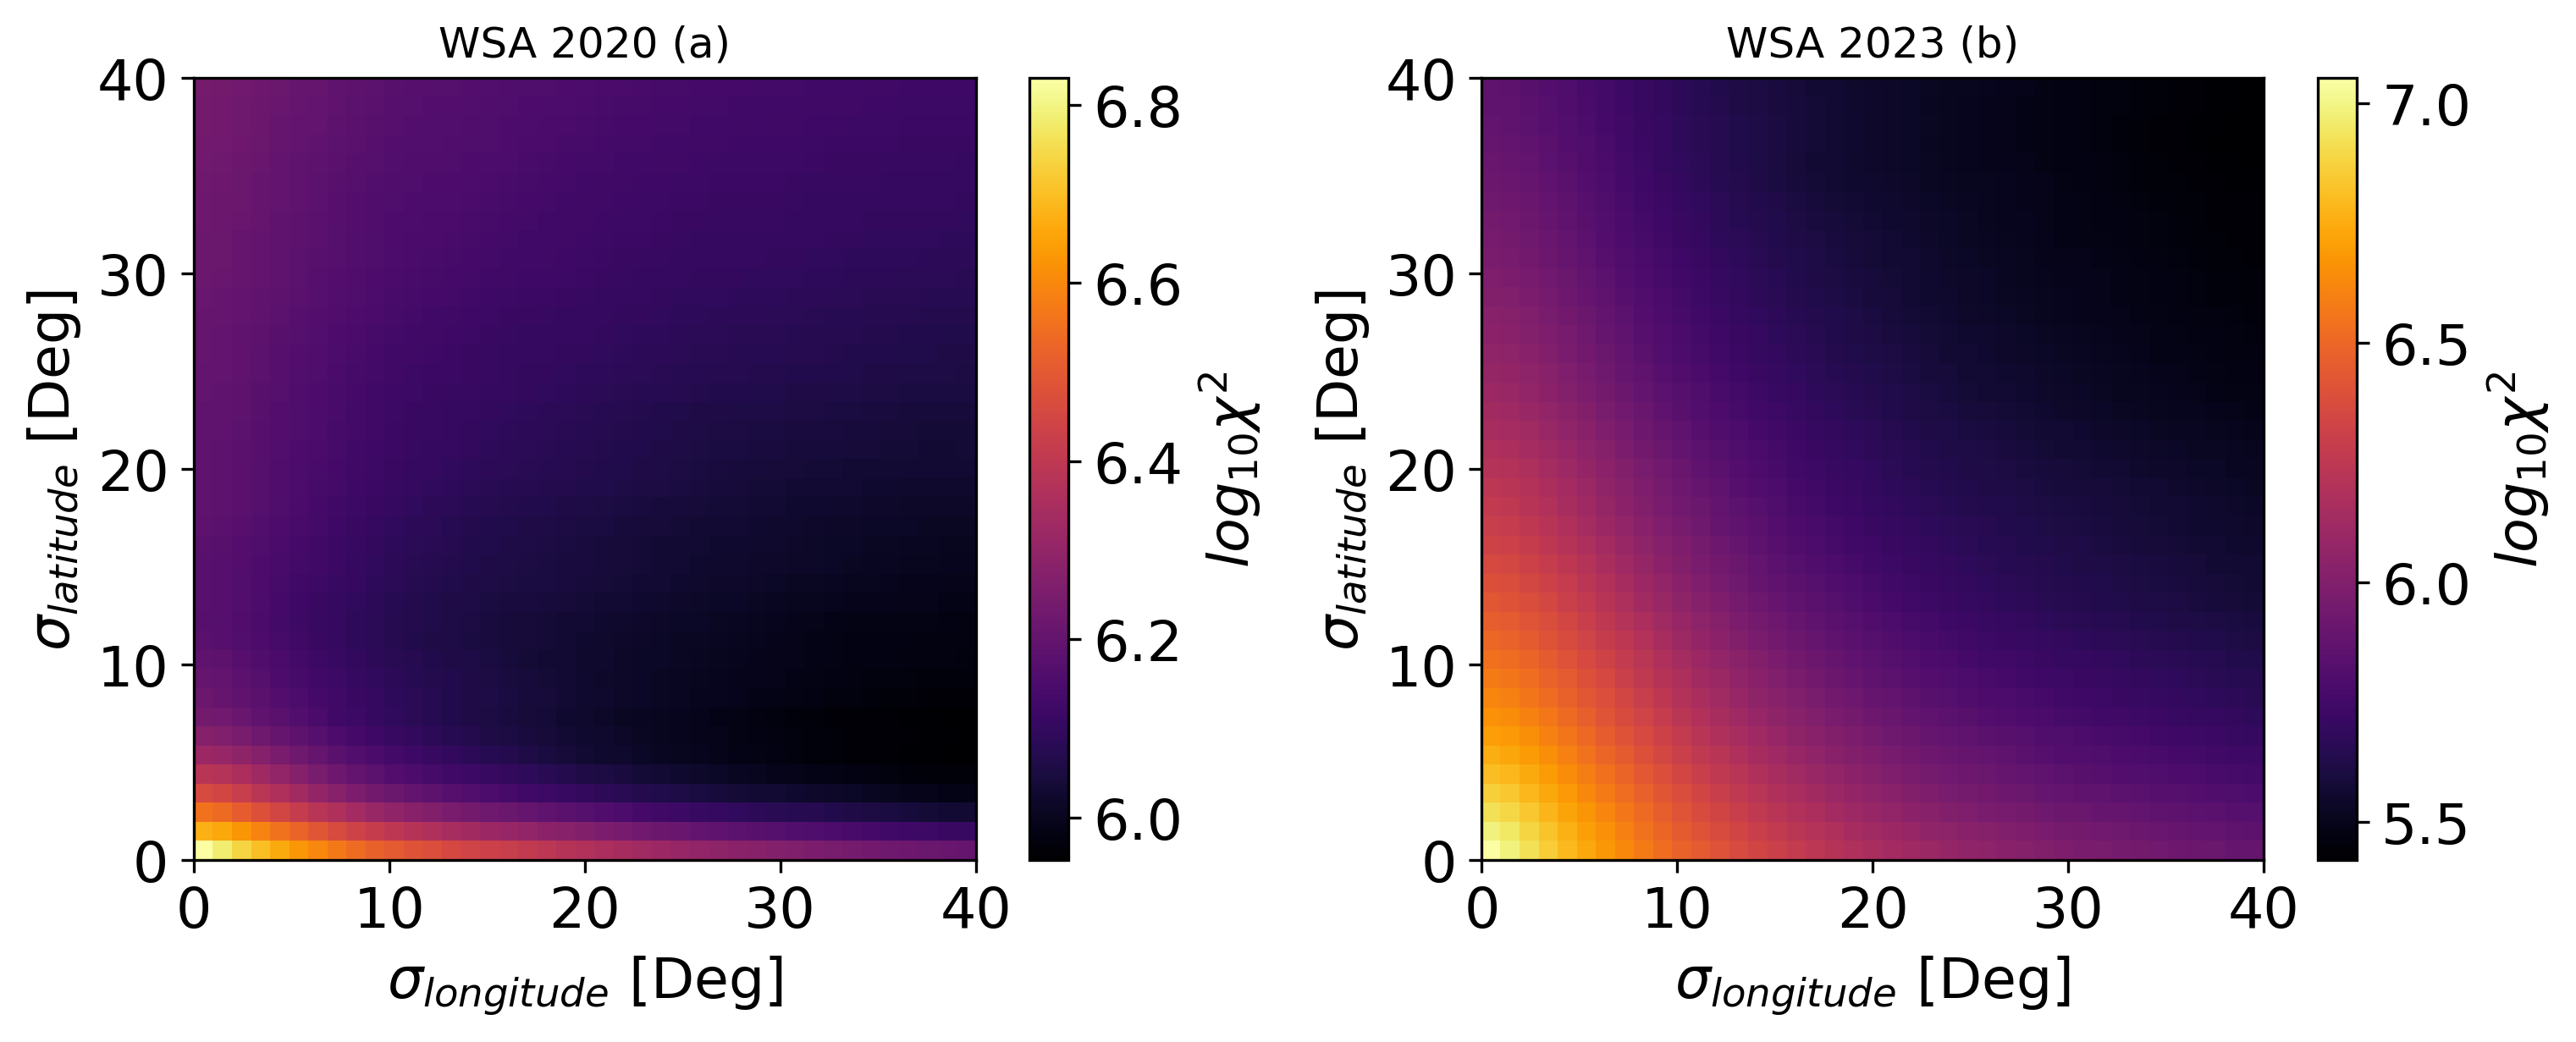

In [12]:
longitudes_to_test = np.linspace(0,40,41)
lead_time=123
gen_dist = '_fullrot'

chi_arr_2023 = [read_chi_arr_by_longitude(era_key='2023', sigma_longitude=lon, lead_time=lead_time, gen_dist=gen_dist) for lon in longitudes_to_test]
chi_arr_2020 = [read_chi_arr_by_longitude(era_key='2020', sigma_longitude=lon, lead_time=lead_time, gen_dist=gen_dist) for lon in longitudes_to_test]

fig, axes = plt.subplots(nrows=1, ncols=2,dpi=300,figsize=(12,4))

axes = axes.flatten()

im = axes[0].imshow(np.log10(chi_arr_2020).T, cmap = 'inferno', origin = 'lower', extent=[0,40,0,40])
axes[0].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
axes[0].set_title('WSA 2020 (a)')


im2 = axes[1].imshow(np.log10(chi_arr_2023).T, cmap = 'inferno', origin = 'lower', extent=[0,40,0,40])
axes[1].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
axes[1].set_title('WSA 2023 (b)')



axes[0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[1].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
#axes[2].set_ylabel(r'$\sigma_{latitude}$ [Deg]')

fig.colorbar(im, ax = axes[0], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)

fig.colorbar(im2, ax = axes[1], label = r'$log_{10}\chi^2$', orientation = 'vertical', aspect = 20, pad = 0.05)

filename = "rank_histogram_arrays_01.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"

plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')
#plt.savefig(fpath, format = 'svg', dpi = 300, bbox_inches='tight')

plt.show()

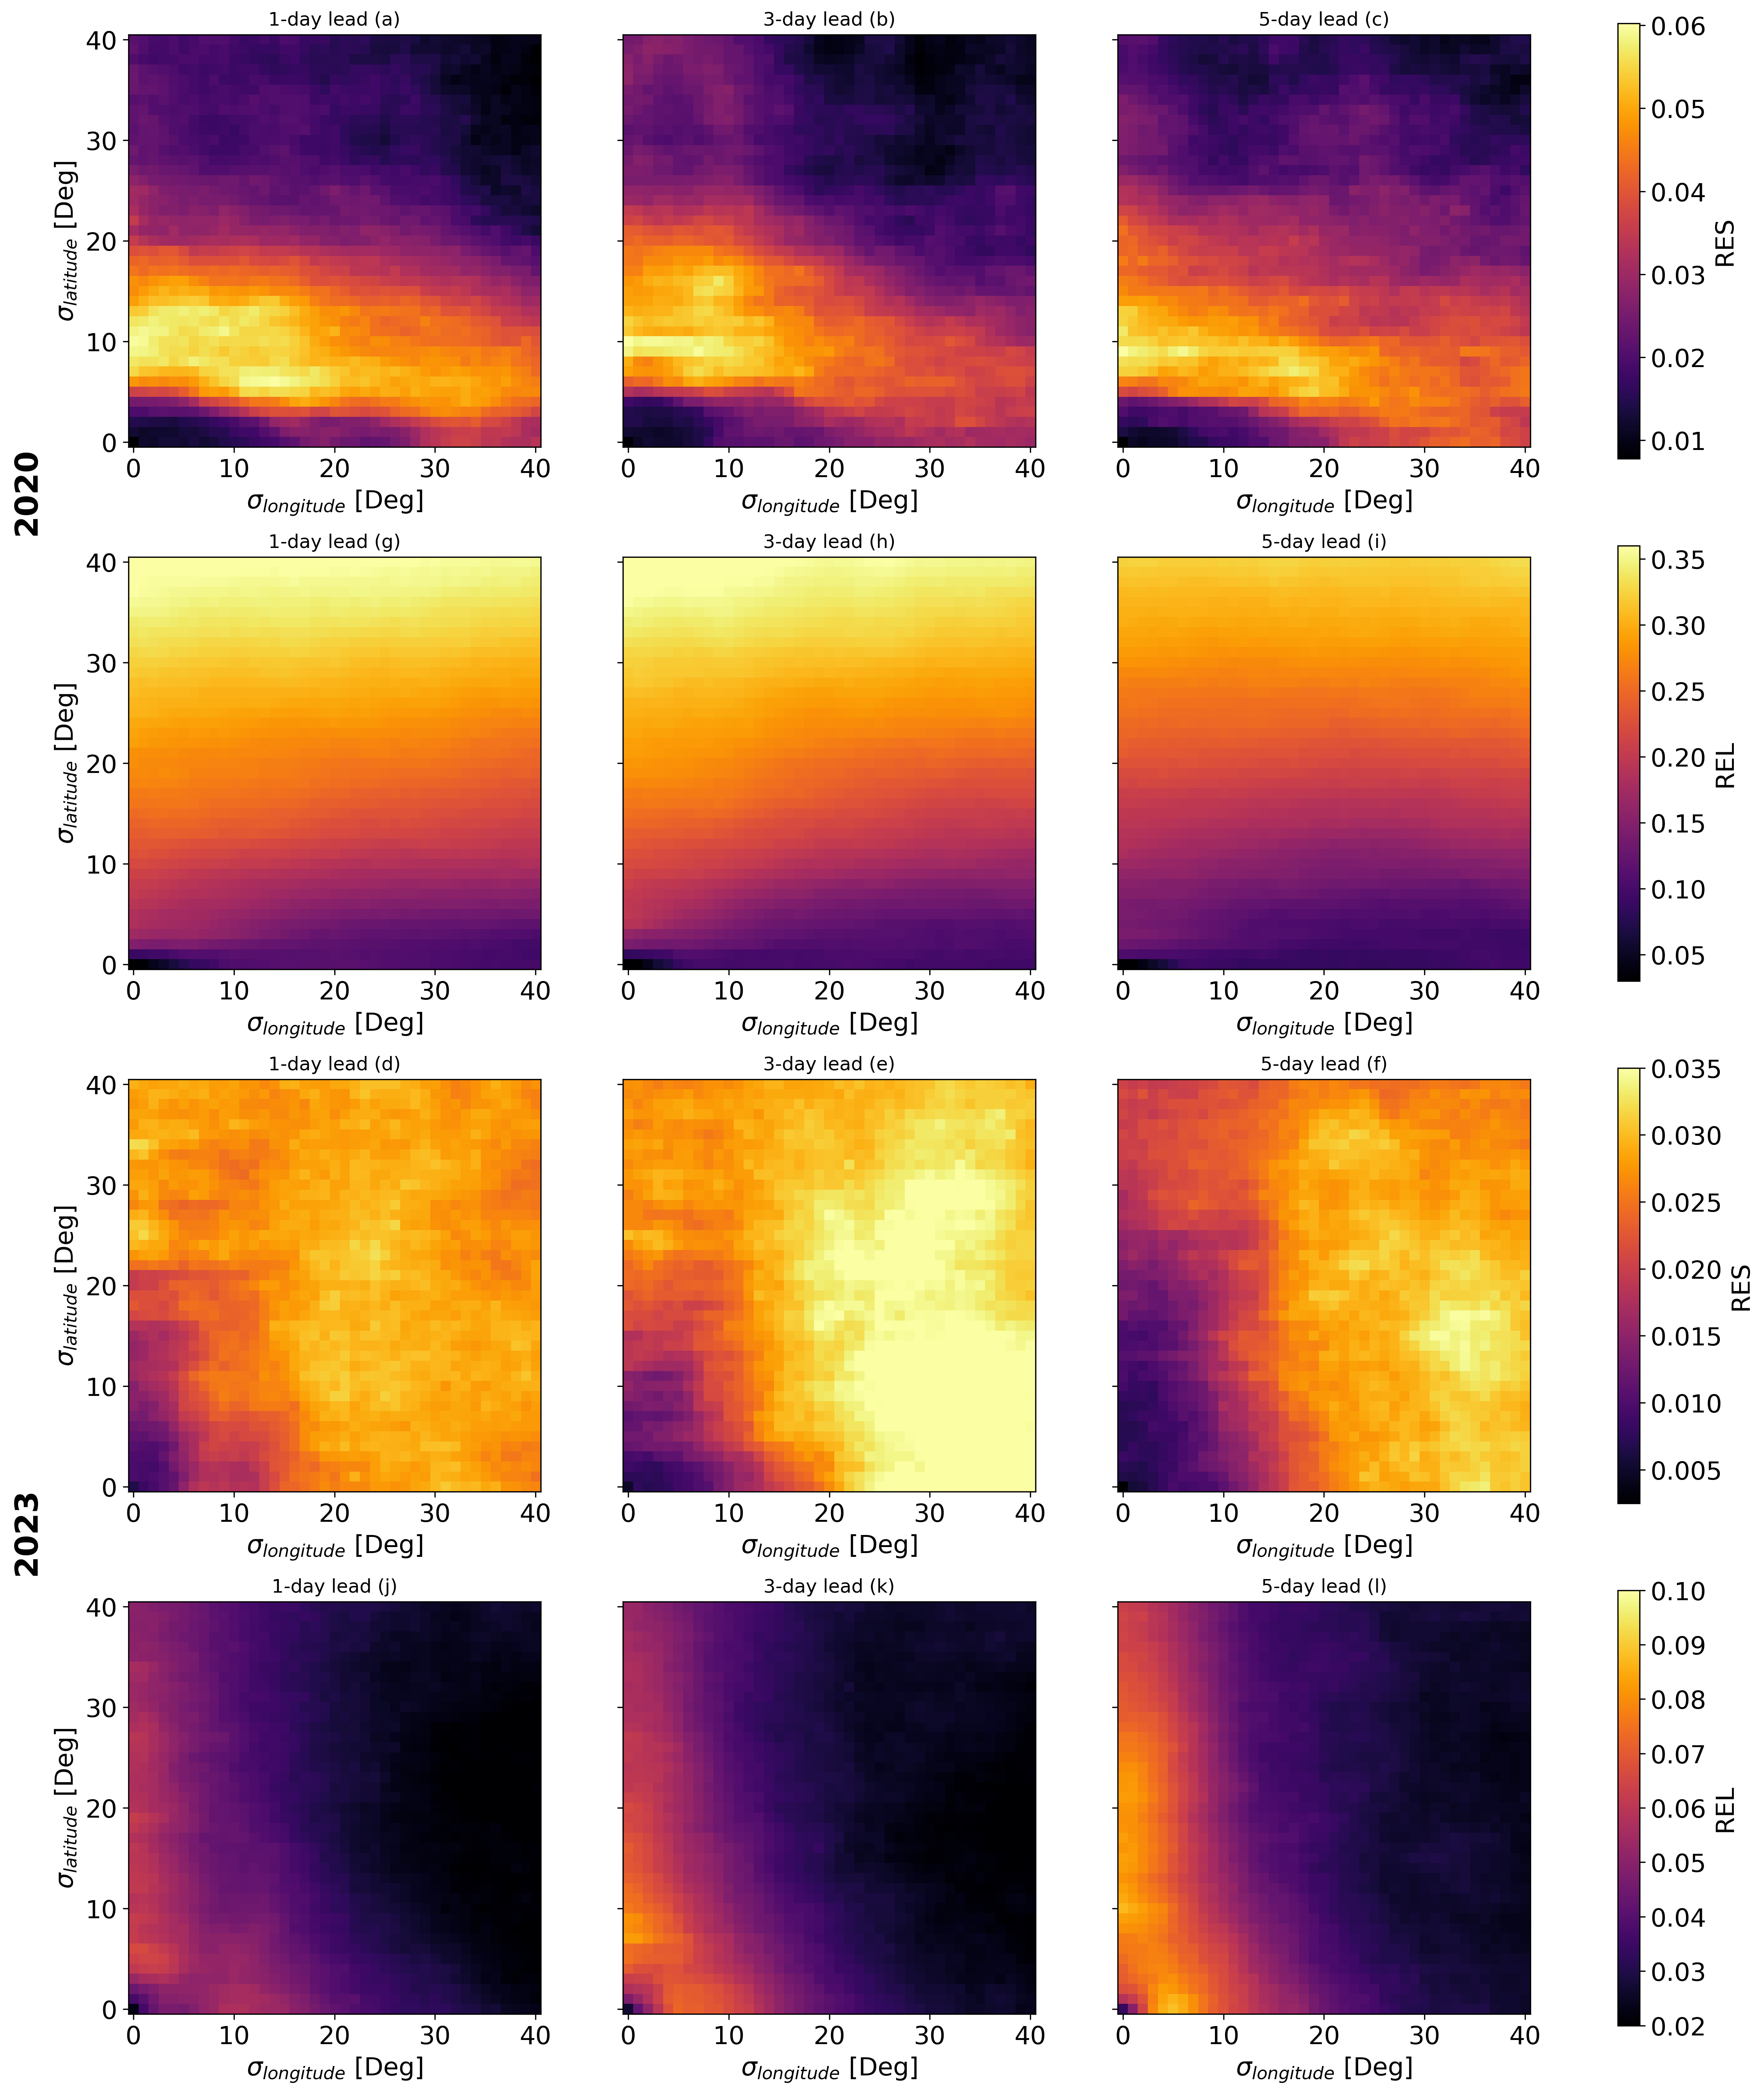

In [ ]:
# relevant bits for reading in files
lead_time_list = [1, 3, 5]
longitudes_to_test = np.linspace(0,40,41)
#event_threshold = 460

# Read in RES and REL components
era_key = '2020'
event_threshold = 419
gen_dist = '_fullrot'

RES_arr_by_lead_2020 = []
for lead_time in lead_time_list:
    RES_arr_temp = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    RES_arr_by_lead_2020.append(np.array(RES_arr_temp).T)

REL_arr_by_lead_2020 = []
for lead_time in lead_time_list:
    REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    REL_arr_by_lead_2020.append(np.array(REL_arr_temp).T)

era_key = '2023'
event_threshold = 460
gen_dist = '_fullrot'
RES_arr_by_lead_2023 = []
for lead_time in lead_time_list:
    RES_arr_temp = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    RES_arr_by_lead_2023.append(np.array(RES_arr_temp).T)


REL_arr_by_lead_2023 = []
for lead_time in lead_time_list:
    REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
    REL_arr_by_lead_2023.append(np.array(REL_arr_temp).T)


# Plotting colourmaps
fig, axes = plt.subplots(nrows=4, ncols=3,dpi=300,figsize=(20,23), sharey=True)

panel_letter = ['(a)','(b)','(c)']
for i, RES_arr in enumerate(RES_arr_by_lead_2020):
    im = axes[0,i].imshow(RES_arr, cmap = 'inferno', origin = 'lower')#, vmin = 0.0025, vmax = 0.05)
    axes[0,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[0,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

panel_letter = ['(d)','(e)','(f)']
for i, RES_arr in enumerate(RES_arr_by_lead_2023):
    im1 = axes[2,i].imshow(RES_arr, cmap = 'inferno', origin = 'lower', vmin = 0.0025, vmax = 0.035)
    axes[2,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[2,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

panel_letter = ['(g)','(h)','(i)']
for i, REL_arr in enumerate(REL_arr_by_lead_2020):
    im2 = axes[1,i].imshow(REL_arr, cmap = 'inferno', origin = 'lower', vmin = 0.03, vmax = 0.36)
    axes[1,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[1,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

panel_letter = ['(j)','(k)','(l)']
for i, REL_arr in enumerate(REL_arr_by_lead_2023):
    im3 = axes[3,i].imshow(REL_arr, cmap = 'inferno', origin = 'lower', vmin = 0.02, vmax = 0.1)
    axes[3,i].set_xlabel(r'$\sigma_{longitude}$ [Deg]')
    axes[3,i].set_title(f'{lead_time_list[i]}-day lead {panel_letter[i]}')

axes[0,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[1,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[2,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')
axes[3,0].set_ylabel(r'$\sigma_{latitude}$ [Deg]')

fig.colorbar(im, ax = axes[0,:], label = r'RES', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im1, ax = axes[2,:], label = r'RES', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im2, ax = axes[1,:], label = r'REL', orientation = 'vertical', aspect = 20, pad = 0.05)
fig.colorbar(im3, ax = axes[3,:], label = r'REL', orientation = 'vertical', aspect = 20, pad = 0.05)

# Add row titles on the left
row_titles_index = [0,2]
row_titles = ['2020', '2023']
for i, row in enumerate(row_titles_index):
    title = row_titles[i]
    fig.text(0.08, 0.7 - (row * 0.2), title, fontsize=20, fontweight='bold', ha='center', va='center', rotation=90)

filename = "wsa_RES_REL_across_lead_time.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')

plt.show()

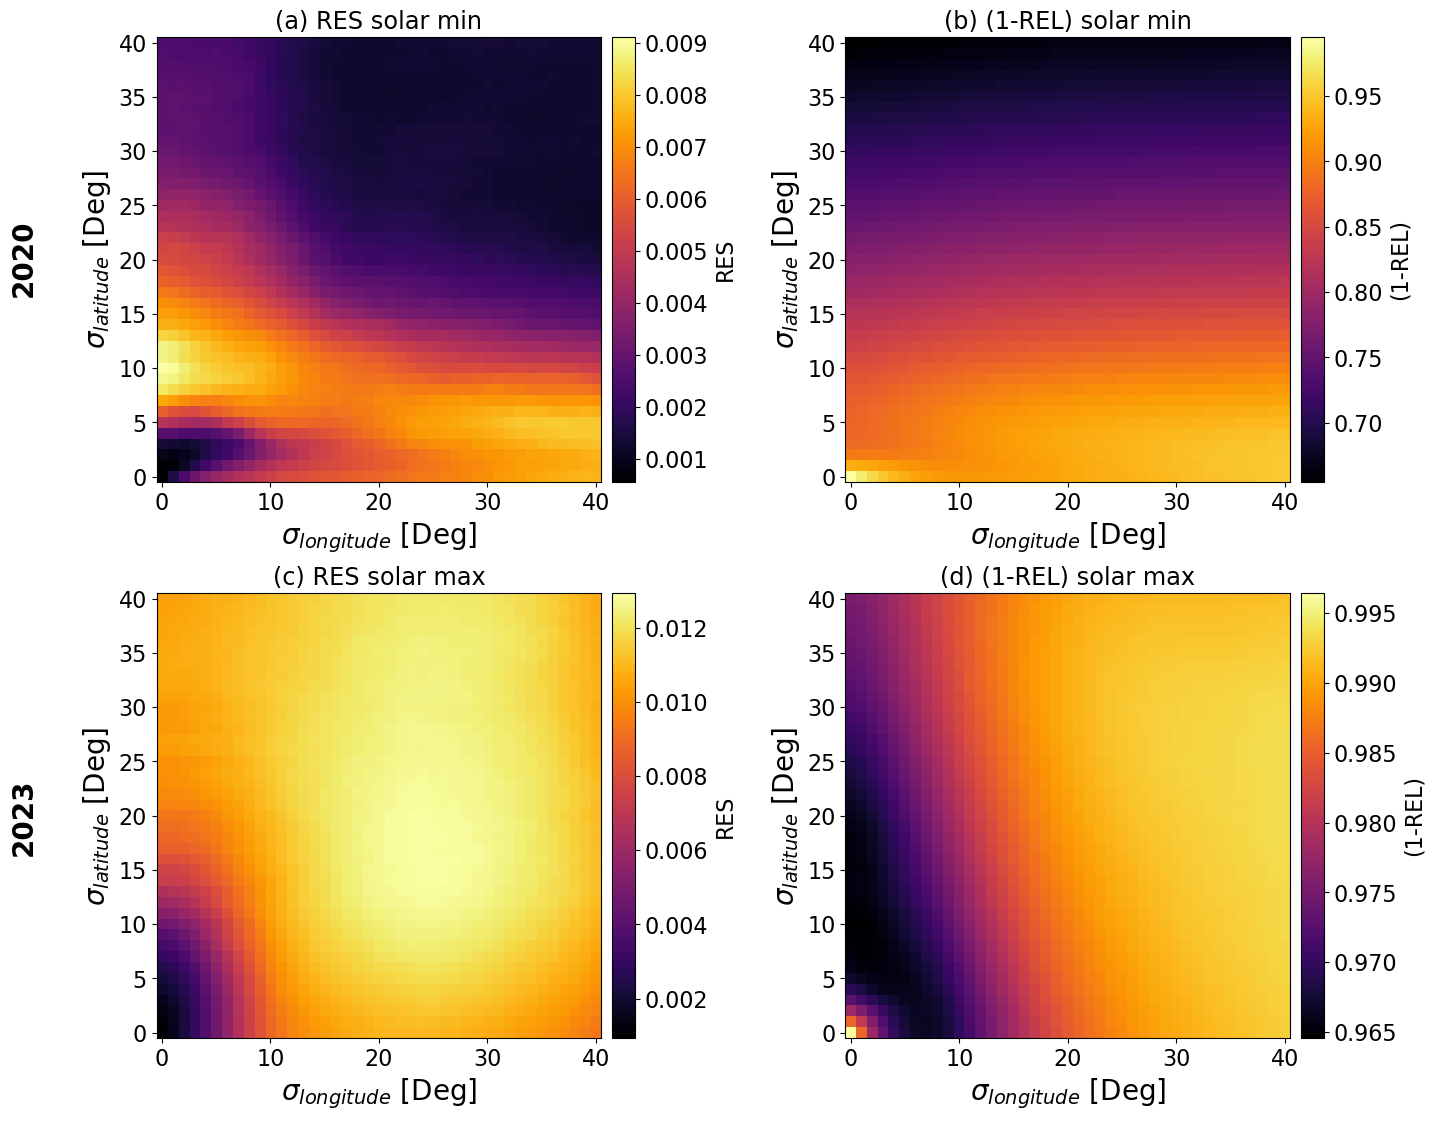

In [43]:
era_key = '2020'
event_threshold = 507
lead_time = 123
gen_dist = '_fullrot'
longitudes_to_test = np.linspace(0,40,41)

RES_arr_temp = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
RES_arr_fullrot_2020 = np.array(RES_arr_temp).T

REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
REL_arr_fullrot_2020 = np.array(REL_arr_temp).T

era_key = '2023'
event_threshold = 553

RES_arr_temp = [read_RES_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
RES_arr_fullrot_2023 = np.array(RES_arr_temp).T

REL_arr_temp = [read_REL_by_longitude(era_key=era_key, sigma_longitude=lon, lead_time=lead_time, threshold=event_threshold, gen_dist=gen_dist) for lon in longitudes_to_test]
REL_arr_fullrot_2023 = np.array(REL_arr_temp).T



fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,13))

axes = axes.flatten()
ft=20

im = axes[0].imshow(RES_arr_fullrot_2020, cmap = 'inferno', origin = 'lower')#, vmin = 0.0025, vmax = 0.05)
axes[0].set_xlabel(r'$\sigma_{longitude}$ [Deg]', fontsize=ft)
axes[0].set_ylabel(r'$\sigma_{latitude}$ [Deg]', fontsize=ft)

im1 = axes[1].imshow(1-REL_arr_fullrot_2020, cmap = 'inferno', origin = 'lower')#, vmin = 0.0025, vmax = 0.05)
axes[1].set_xlabel(r'$\sigma_{longitude}$ [Deg]', fontsize=ft)
axes[1].set_ylabel(r'$\sigma_{latitude}$ [Deg]', fontsize=ft)

im2 = axes[2].imshow(RES_arr_fullrot_2023, cmap = 'inferno', origin = 'lower')#, vmin = 0.0025, vmax = 0.05)
axes[2].set_xlabel(r'$\sigma_{longitude}$ [Deg]', fontsize=ft)
axes[2].set_ylabel(r'$\sigma_{latitude}$ [Deg]', fontsize=ft)


im3 = axes[3].imshow(1-REL_arr_fullrot_2023, cmap = 'inferno', origin = 'lower')#, vmin = 0.0025, vmax = 0.05)
axes[3].set_xlabel(r'$\sigma_{longitude}$ [Deg]', fontsize=ft)
axes[3].set_ylabel(r'$\sigma_{latitude}$ [Deg]', fontsize=ft)


panel_label = ['(a) RES solar min', '(b) (1-REL) solar min', '(c) RES solar max', '(d) (1-REL) solar max']

fig.text(0.05, 0.71, '2020', fontsize=20, fontweight='bold', ha='center', va='center', rotation=90)
fig.text(0.05, 0.28, '2023', fontsize=20, fontweight='bold', ha='center', va='center', rotation=90)

for i, ax in enumerate(axes):
    ax.set_title(panel_label[i], fontsize='xx-large')


fig.colorbar(im, ax = axes[0], label = r'RES', orientation = 'vertical', aspect = 20, pad = 0.02)
fig.colorbar(im1, ax = axes[1], label = r'(1-REL)', orientation = 'vertical', aspect = 20, pad = 0.02)
fig.colorbar(im2, ax = axes[2], label = r'RES', orientation = 'vertical', aspect = 20, pad = 0.02)
fig.colorbar(im3, ax = axes[3], label = r'(1-REL)', orientation = 'vertical', aspect = 20, pad = 0.02)
plt.subplots_adjust(wspace=0.25, hspace=0.25)


filename = "wsa_RES_REL.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"
plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')

plt.show()

In [47]:
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)
action_threshold = np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)
print(action_threshold)

553.0


['ens_0_100_wsa_2020_fullrot']
['ens_5_100_wsa_2020_fullrot']
['ens_5_100_wsa_2020_fullrot']
['ens_5_100_wsa_2020_fullrot']
['ens_5_100_wsa_2020_fullrot']
['ens_10_100_wsa_2020_fullrot']
['ens_15_100_wsa_2020_fullrot']


<Figure size 6000x3000 with 0 Axes>

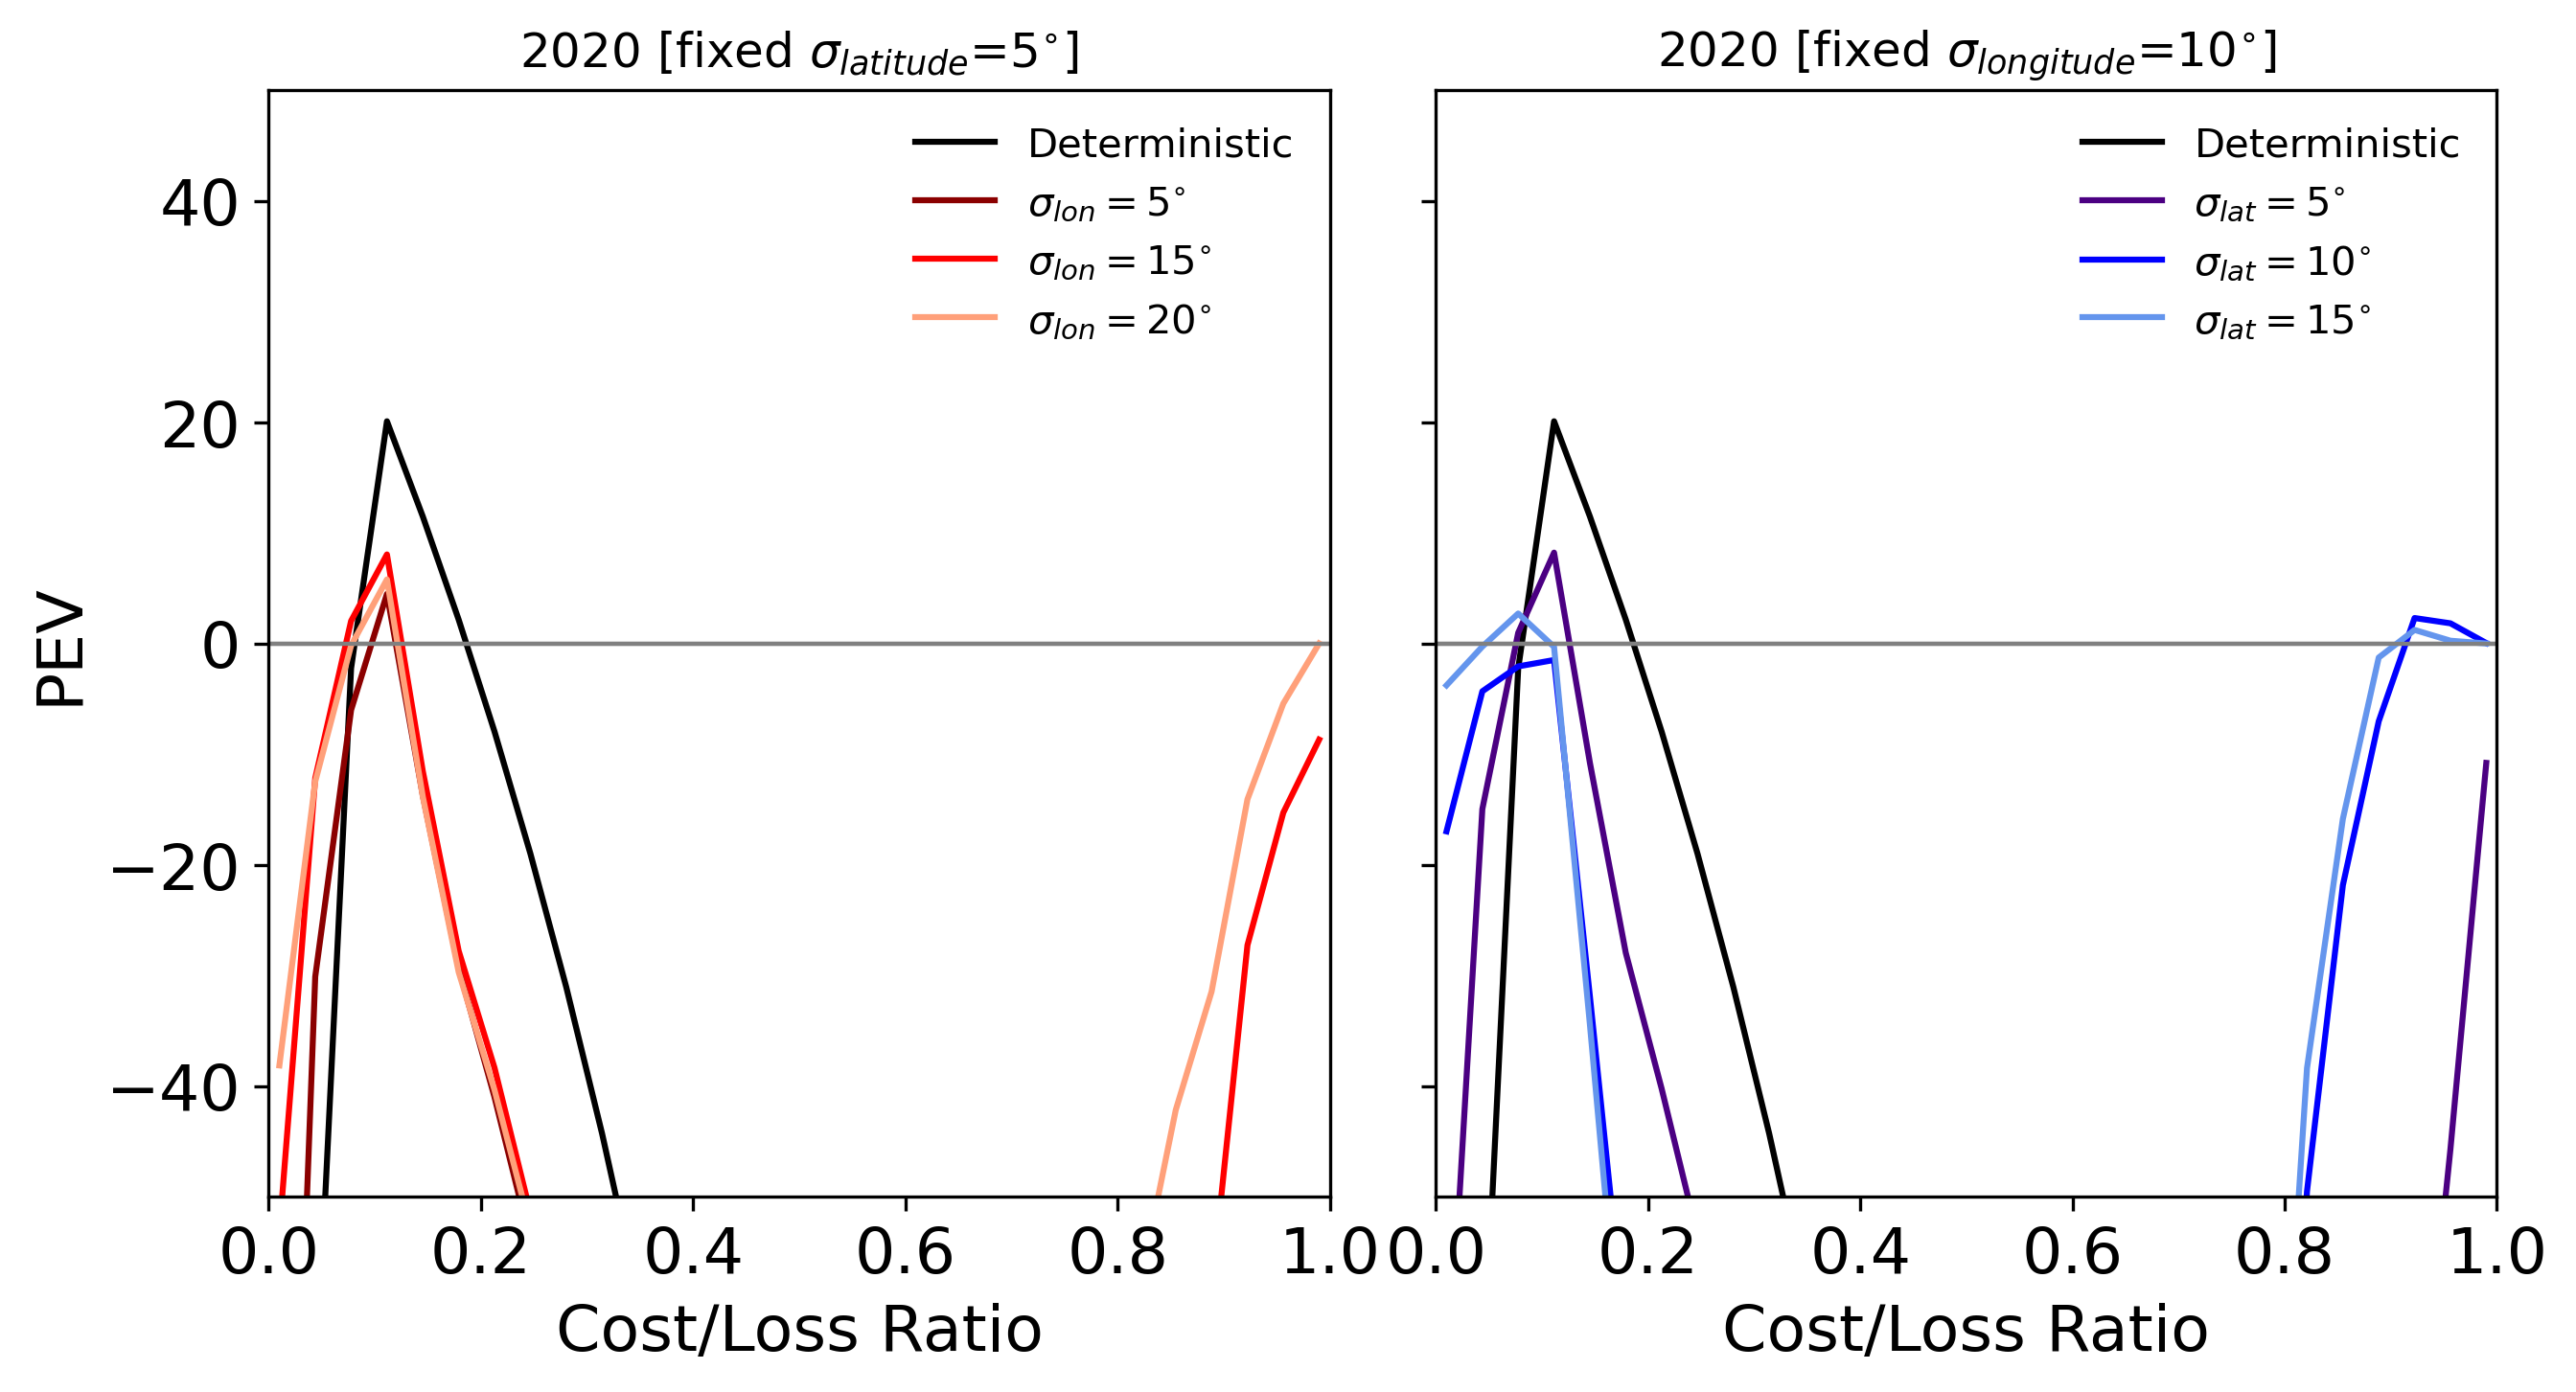

In [11]:
fig = plt.figure(figsize = (20,10), dpi=300)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=300, sharex=True, sharey=True)


# specify year + date range of ensembles to load in
year_str = '2020'
gen_dist = '_fullrot'
start_date = datetime.datetime(2020,6,1)
end_date = datetime.datetime(2021,1,1)
ensemble_size = 100

deterministic_ensemble_sets = read_daily_ensemble_sets(ensemble_size, 0, 0, year_str, start_date, end_date, gen_dist, df_filtered) # reading in data

# Define cost/loss bins
cost_loss_ratios = np.linspace(0.01,0.99,30)
linestyles = ['-','--',':']

# Action thresholds for cost/loss
action_threshold = np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)

df_ = pd.concat(deterministic_ensemble_sets.copy())


df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

# initalise lists to store Potential Economic Values across the cost/loss ratio bins 
probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
action_threshold_data = df_['observation'] > action_threshold

# loop through cost/loss ratios
PEV_list = []
for cl in cost_loss_ratios:
    
    # set cl ratio as probability threshold
    prob_thresh = cl
    # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
    ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
    PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))

for ax in axes:
    ax.plot(cost_loss_ratios, PEV_list, color = 'black', label='Deterministic')
    ax.axhline(0, lw = 1, color = 'grey')
    ax.set_xlim(0,1)
    ax.set_ylim(-50,50)
    #ax.set_xticks([0,0.5])
    # ax.set_ylabel('PEV [%]')
        
    # ax.set_xticks([])

axes[0].set_ylabel('PEV')
axes[0].set_xlabel('Cost/Loss Ratio')

sigma_latitude = 5
sigma_longitudes = [5,15,20]
color_thresh = ['darkred', 'red', 'lightsalmon']

for m, sigma_longitude in enumerate(sigma_longitudes):

    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist, df_filtered) # reading in data
    #lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_threshold = np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)

    df_ = pd.concat(daily_ensemble_sets).copy()

    df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

    probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
    action_threshold_data = df_['observation'] > action_threshold

    # loop through cost/loss ratios
    PEV_list = []
    for cl in cost_loss_ratios:
        
        # set cl ratio as probability threshold
        prob_thresh = cl
        # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
        ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
        PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                    losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
    
    
    axes[0].plot(cost_loss_ratios, PEV_list, color = color_thresh[m], label=f'$\sigma_{{lon}}={sigma_longitude}^{{\circ}}$')
    axes[0].axhline(0, lw = 1, color = 'grey')
    axes[0].set_xlim(0,1)
    axes[0].set_ylim(-50,50)
    axes[0].set_title(f'2020 [fixed $\sigma_{{latitude}}$={sigma_latitude}$^{{\circ}}$]')


axes[0].legend(frameon=False, fontsize='medium')

sigma_longitude = 10
sigma_latitudes = [5,10,15]
color_thresh = ['indigo', 'blue', 'cornflowerblue']

for m, sigma_latitude in enumerate(sigma_latitudes):

    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist, df_filtered) # reading in data
    #lead_time_dict = split_into_lead_time_sections(10, daily_ensemble_sets) # split into chunks by lead time

    action_threshold = np.nanpercentile(df_filtered['V'].loc[start_date:end_date], 90)

    df_ = pd.concat(daily_ensemble_sets).copy()

    df_[f'prob_{int(action_threshold)}'] = np.mean(df_.filter(like='vsw') > action_threshold, axis=1)

    probabilistic_forecast = df_[f'prob_{int(action_threshold)}']
    action_threshold_data = df_['observation'] > action_threshold

    # loop through cost/loss ratios
    PEV_list = []
    for cl in cost_loss_ratios:
        
        # set cl ratio as probability threshold
        prob_thresh = cl
        # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
        ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
        PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                    losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))

    axes[1].plot(cost_loss_ratios, PEV_list, color = color_thresh[m], label=f'$\sigma_{{lat}}={sigma_latitude}^{{\circ}}$')
    axes[1].axhline(0, lw = 1, color = 'grey')
    axes[1].set_xlim(0,1)
    axes[1].set_ylim(-50,50)

axes[1].set_title(f'2020 [fixed $\sigma_{{longitude}}$={sigma_longitude}$^{{\circ}}$]')
axes[1].legend(frameon=False, fontsize='medium')
axes[1].set_xlabel('Cost/Loss Ratio')

fig.subplots_adjust(wspace=0.1, hspace=0.05)

filename = "COSTLOSS_2020.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"
plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')


plt.show()

In [40]:
# ensemble parameters
ensemble_size = 100
#sigma_latitude = 5 # degrees
sigma_longitude = 10 # degrees
year_str = '2023'
gen_dist = '_fullrot'

# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)

#longitudes_to_test = [0,5,10,15,20]
latitudes_to_test = [0,5,10,15,20]

daily_crpss_across_longitude = []
daily_crps_across_longitude = []
cont_crpss_across_longitude = []
cont_crps_across_longitude = []

for sigma_latitude in latitudes_to_test:
#for sigma_longitude in longitudes_to_test:

    daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, gen_dist, df_filtered)
    climatology = df_filtered.loc['2023-01':'2023-12']['V'].mean()
    print(sigma_longitude)
    #print(f'Climatological wind speed = {climatology:.3f} km/s')

    crps_ensemble_evaluation(daily_ensemble_sets)

    crpss_sets = []
    crps_sets = []
    for df_ in daily_ensemble_sets:
        crpss_sets.append(df_['crpss'].iloc[0:640])
        crps_sets.append(df_['crps'].iloc[0:640])

    lead_time_axis = np.linspace(1,27,640)

    #crpss_mean = []
    crpss_daily_median = []
    crps_daily_median = []
    for i in range(27):
        index = (lead_time_axis > i+1) & (lead_time_axis < (i+2))
        #crpss_mean.append(np.nanmean([crpss[index] for crpss in crpss_sets]))
        crpss_daily_median.append(np.nanmedian([crpss[index] for crpss in crpss_sets]))
        crps_daily_median.append(np.nanmedian([crps[index] for crps in crps_sets]))
    
    daily_crpss_across_longitude.append(crpss_daily_median)
    cont_crpss_across_longitude.append(np.nanmedian(crpss_sets, axis=0))
    daily_crps_across_longitude.append(crps_daily_median)
    cont_crps_across_longitude.append(np.nanmedian(crps_sets, axis=0))


['ens_0_100_wsa_2023_fullrot']
10


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_5_100_wsa_2023_fullrot']
10


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_10_100_wsa_2023_fullrot']
10


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_15_100_wsa_2023_fullrot']
10


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


['ens_20_100_wsa_2023_fullrot']
10


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(50.0, 70.0)

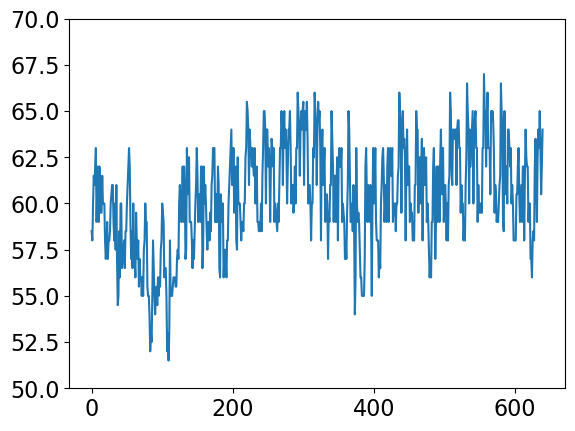

In [37]:
climate_sets = []
for df_ in daily_ensemble_sets:
    climate_sets.append(df_['crps_climate'].iloc[0:640])

plt.plot(np.nanmedian(climate_sets, axis=0))
plt.ylim(50,70)

In [41]:

longitudes_to_test = [0,5,10,15,20]
latitudes_to_test = [0,5,10,15,20]
year = 2023


# for i,longs in enumerate(longitudes_to_test):

#     fname_crps = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crps_long_{longs}_{year}.txt'
#     fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_long_{longs}_{year}.txt'
#     fname_crps_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crps_long_{longs}_{year}.txt'
#     fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_long_{longs}_{year}.txt'

#     np.savetxt(fname_crps, daily_crps_across_longitude[i])
#     np.savetxt(fname_crpss, daily_crpss_across_longitude[i])
#     np.savetxt(fname_crps_cont, cont_crps_across_longitude[i])
#     np.savetxt(fname_crpss_cont, cont_crpss_across_longitude[i])

for i,lats in enumerate(latitudes_to_test):

    fname_crps = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crps_lats_{lats}_{year}.txt'
    fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_lats_{lats}_{year}.txt'
    fname_crps_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crps_lats_{lats}_{year}.txt'
    fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_lats_{lats}_{year}.txt'

    np.savetxt(fname_crps, daily_crps_across_longitude[i])
    np.savetxt(fname_crpss, daily_crpss_across_longitude[i])
    np.savetxt(fname_crps_cont, cont_crps_across_longitude[i])
    np.savetxt(fname_crpss_cont, cont_crpss_across_longitude[i])

In [9]:
ensemble_size=100
year_str = '2023'
gen_dist = '_fullrot'
# specify date range of ensemble to load in
start_date = datetime.datetime(2023,1,1)
end_date = datetime.datetime(2024,1,1)


daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, 0, 0, year_str, start_date, end_date, gen_dist, df_filtered)
climatology = df_filtered.loc['2023-01':'2023-12']['V'].mean()

crps_ensemble_evaluation(daily_ensemble_sets)

crpss_sets = []
for df_ in daily_ensemble_sets:
    crpss_sets.append(df_['crpss'].iloc[0:640])

lead_time_axis = np.linspace(1,27,640)

#crpss_mean = []
deterministic_crpss_median = []
for i in range(27):
    index = (lead_time_axis > i+1) & (lead_time_axis < (i+2))
    #crpss_mean.append(np.nanmean([crpss[index] for crpss in crpss_sets]))
    deterministic_crpss_median.append(np.nanmedian([crpss[index] for crpss in crpss_sets]))


['ens_0_100_wsa_2023_fullrot']


c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [80]:
deterministic_crpss_series = np.nanmedian(crpss_sets, axis=0)

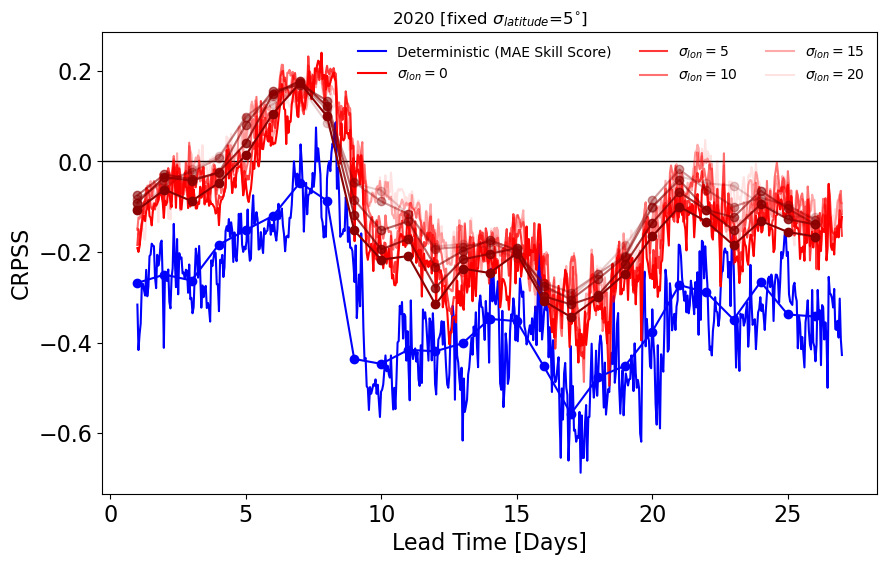

In [ ]:

lead_time_axis = np.linspace(1,27,640)

plt.figure(figsize = (10,6))
plt.axhline(0, lw=1, color='black')


plt.plot(np.linspace(1,27,len(cont_crpss_across_longitude[0])), deterministic_crpss_series, color = 'blue', label = f'Deterministic (MAE Skill Score)')

for i, crpss_med in enumerate(cont_crpss_across_longitude):
    plt.plot(np.linspace(1,27,len(crpss_med)), crpss_med, color = 'red', alpha = 1-i/4.5, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')

plt.plot(np.linspace(1,27,len(daily_crpss_across_longitude[0])), deterministic_crpss_median, color = 'blue', marker = 'o', linestyle='-')

for i, crpss_med in enumerate(daily_crpss_across_longitude):
    plt.plot(np.linspace(1,27,len(crpss_med)), crpss_med, color = 'darkred', alpha = 1-i/5, marker = 'o', linestyle='-')#, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')


plt.legend(frameon = False, ncols=3, fontsize='medium')
plt.ylabel('CRPSS')
plt.xlabel('Lead Time [Days]')
plt.title(f'2020 [fixed $\sigma_{{latitude}}$={sigma_latitude}$^{{\circ}}$]')

filename = "CRPSS_2020_across_lon.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_02\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')


plt.show()


In [ ]:
longitudes_to_test = [0,5,10,15,20]

year = 2023

cont_crpss_across_longitude = []
cont_crps_across_longitude = []
daily_crpss_across_longitude = []
daily_crps_across_longitude = []

for longs in longitudes_to_test:
        fname_crps = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crps_long_{longs}_{year}.txt'
        fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_long_{longs}_{year}.txt'
        fname_crps_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crps_long_{longs}_{year}.txt'
        fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_long_{longs}_{year}.txt'
        cont_crps_across_longitude.append(np.genfromtxt(fname_crps_cont))
        cont_crpss_across_longitude.append(np.genfromtxt(fname_crpss_cont))
        daily_crps_across_longitude.append(np.genfromtxt(fname_crps))
        daily_crpss_across_longitude.append(np.genfromtxt(fname_crpss))


lead_time_axis = np.linspace(1,27,640)

# Take colors at regular intervals spanning the colormap.
cmap = mpl.colormaps['inferno']
colors = cmap(np.linspace(0, 0.7, len(longitudes_to_test)))

plt.figure(figsize = (10,6))
#plt.axhline(0, lw=1, color='black')


#plt.plot(np.linspace(1,27,len(cont_crpss_across_longitude[0])), deterministic_crpss_series, color = 'blue', label = f'Deterministic (MAE Skill Score)')

for i, crpss_med in enumerate(cont_crpss_across_longitude):
    plt.plot(np.linspace(1,27,len(crpss_med)), crpss_med, color = colors[i], alpha = 0.7, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')

#plt.plot(np.linspace(1,27,len(daily_crpss_across_longitude[0])), deterministic_crpss_median, color = 'blue', marker = 'o', linestyle='-')

for i, crpss_med in enumerate(daily_crpss_across_longitude):
    plt.plot(np.linspace(1,27,len(crpss_med)), crpss_med, color = colors[i], alpha = 1, marker = 'o', linestyle='-')#, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')

sigma_latitude=5
plt.legend(frameon = False, ncols=3, fontsize='medium')
plt.ylabel('CRPSS')
plt.xlabel('Lead Time [Days]')
plt.title(f'2020 [fixed $\sigma_{{latitude}}$={sigma_latitude}$^{{\circ}}$]')


FileNotFoundError: C:\Users\ct832900\Desktop\Research_Code\WSA_calibration\data\CRPS\cont_crps_long_0_2023.txt not found.

C:\Users\ct832900\AppData\Local\Temp\ipykernel_18716\3415365395.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


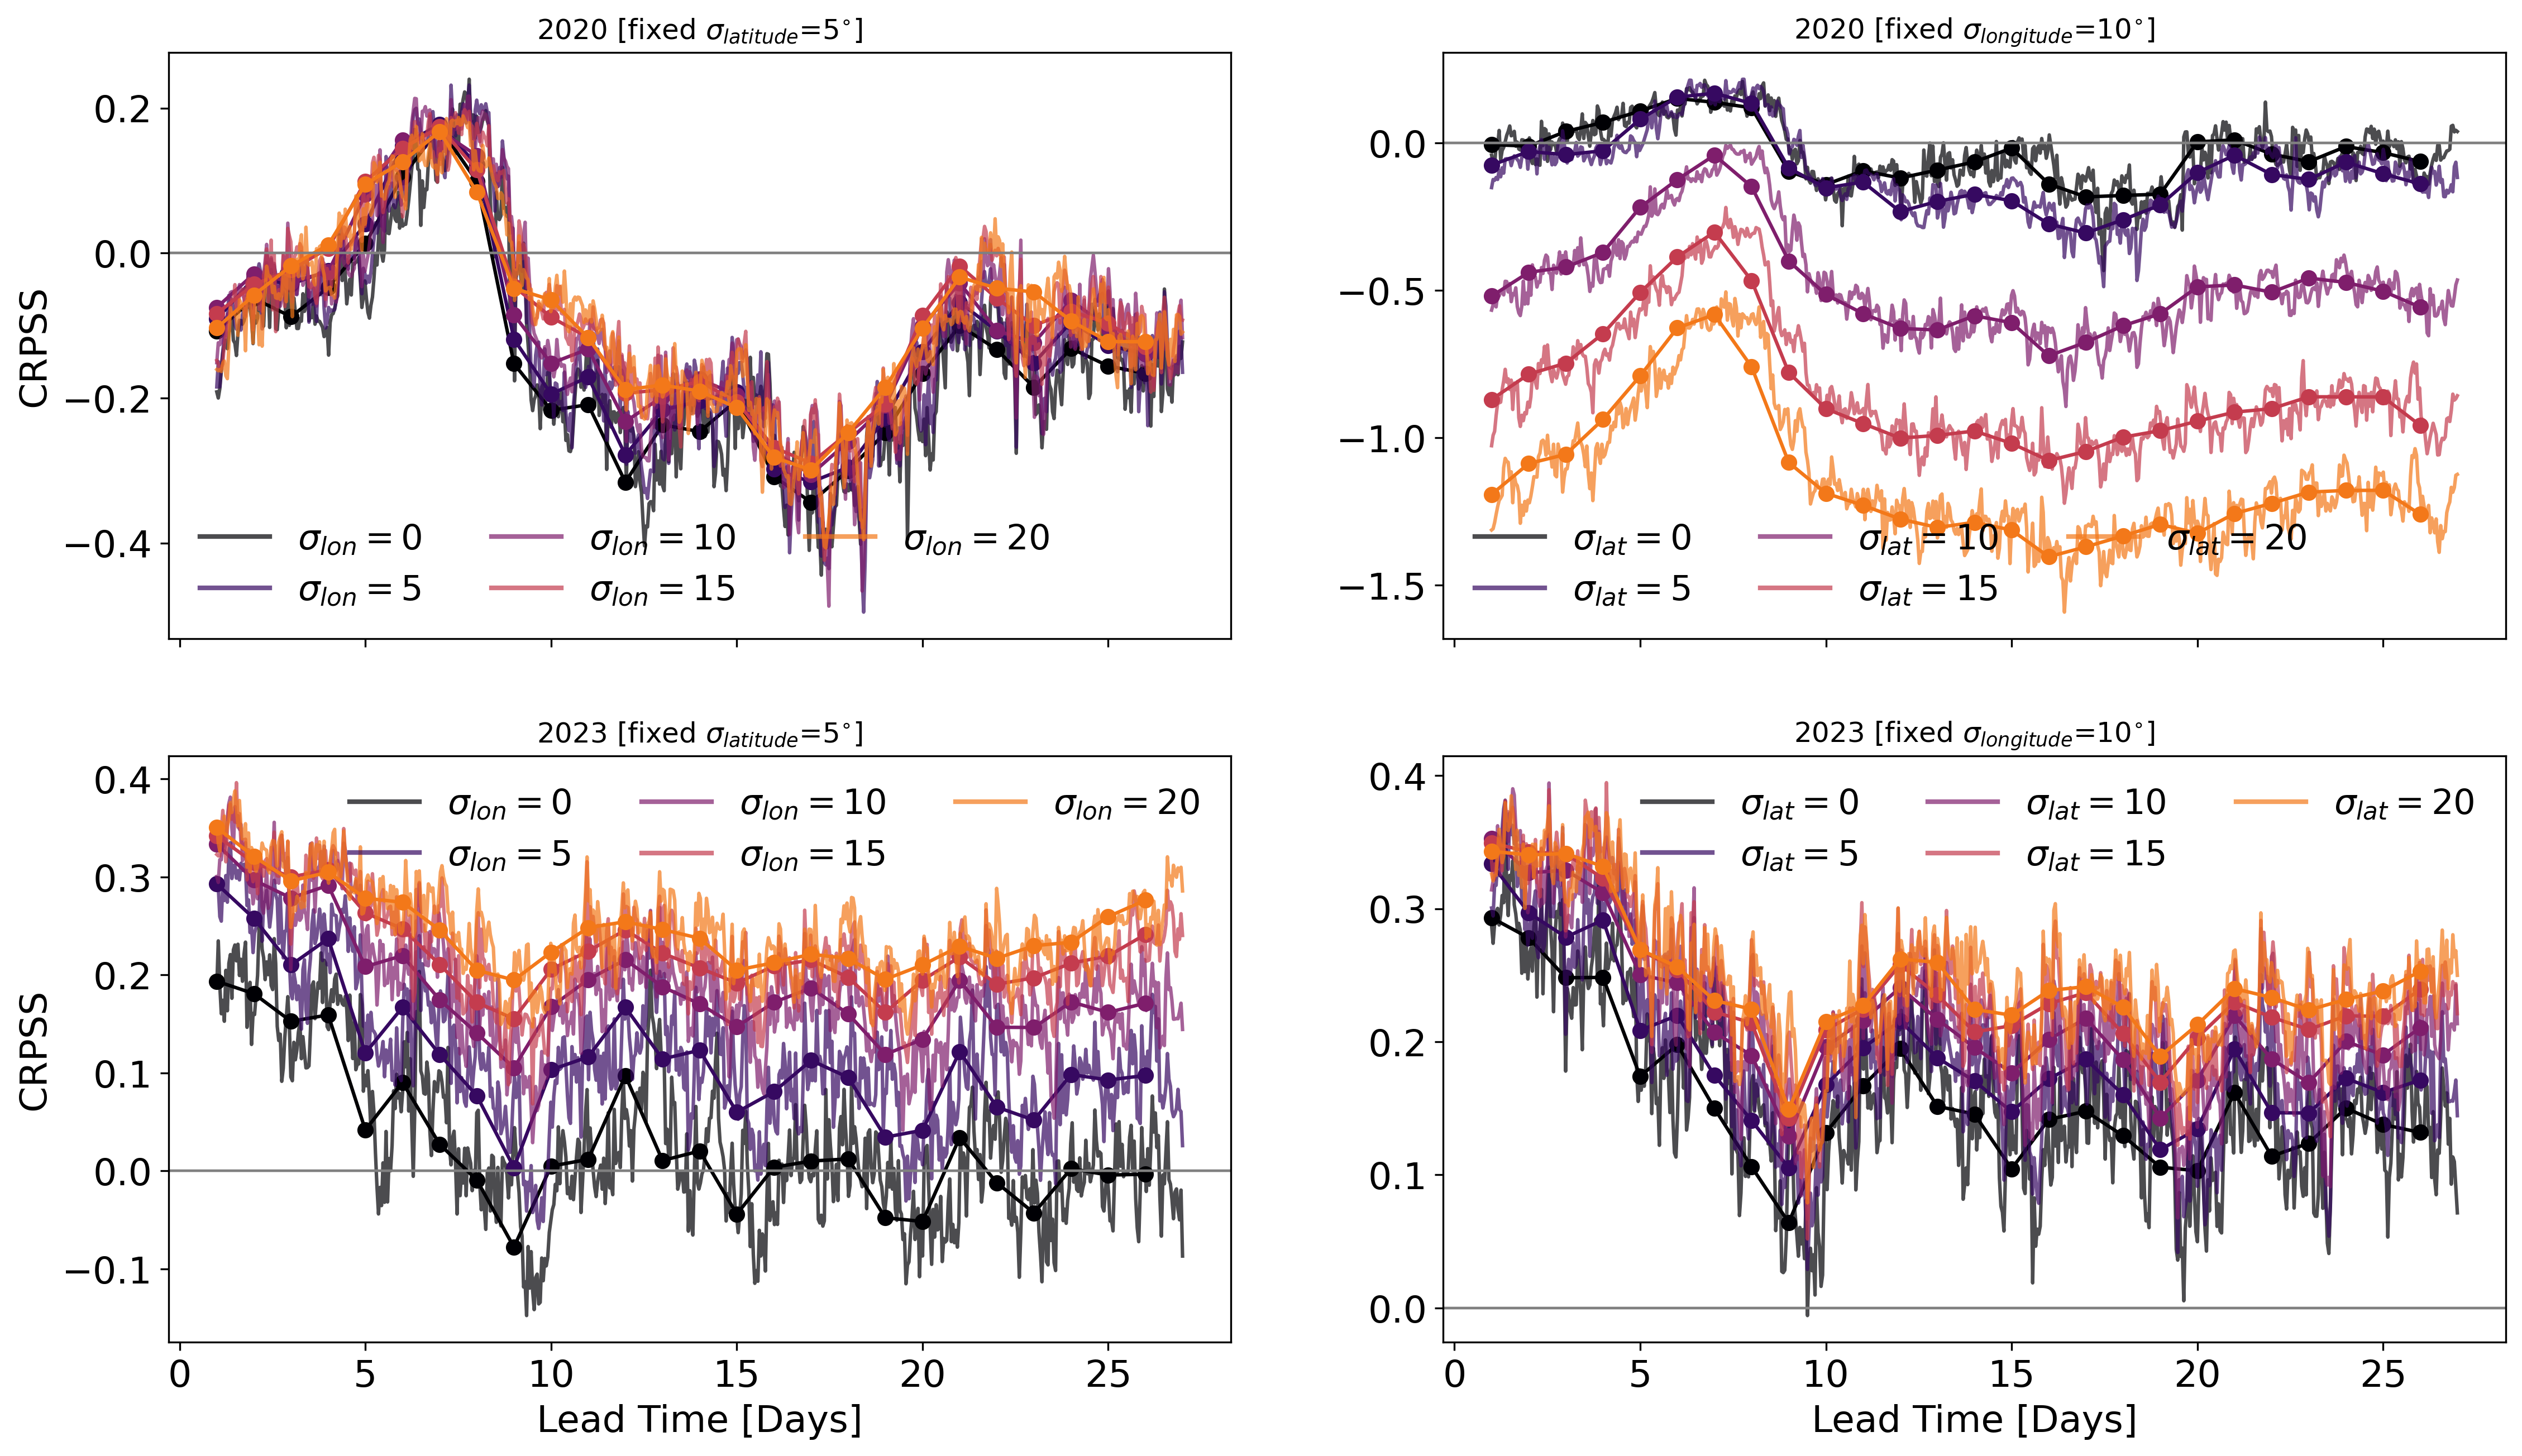

In [42]:
longitudes_to_test = [0,5,10,15,20]
latitudes_to_test = [0,5,10,15,20]




fig, axes = plt.subplots(nrows=2, ncols=2, dpi=300, figsize=(18,10), sharex=True)

# Take colors at regular intervals spanning the colormap.
cmap = mpl.colormaps['inferno']
colors = cmap(np.linspace(0, 0.7, len(longitudes_to_test)))


year=2020
sigma_latitude=5
ax1 = axes[0,0]
for i, longs in enumerate(longitudes_to_test):
    fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_long_{longs}_{year}.txt'
    fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_long_{longs}_{year}.txt'

    crpss_cont = np.genfromtxt(fname_crpss_cont)
    crpss_daily = np.genfromtxt(fname_crpss)


    ax1.plot(np.linspace(1,27,len(crpss_cont)), crpss_cont, color = colors[i], alpha = 0.7, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')
    ax1.plot(np.linspace(1,27,len(crpss_daily)), crpss_daily, color = colors[i], alpha = 1, marker = 'o', linestyle='-')
    ax1.axhline(0, color='grey', lw=1)
    ax1.set_title(f'2020 [fixed $\sigma_{{latitude}}$={sigma_latitude}$^{{\circ}}$]')
        

year=2020
sigma_longitude=10
ax2 = axes[0,1]
for i, lats in enumerate(latitudes_to_test):
    fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_lats_{lats}_{year}.txt'
    fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_lats_{lats}_{year}.txt'

    crpss_cont = np.genfromtxt(fname_crpss_cont)
    crpss_daily = np.genfromtxt(fname_crpss)

    ax2.plot(np.linspace(1,27,len(crpss_cont)), crpss_cont, color = colors[i], alpha = 0.7, label = f'$\sigma_{{lat}}={latitudes_to_test[i]}$')
    ax2.plot(np.linspace(1,27,len(crpss_daily)), crpss_daily, color = colors[i], alpha = 1, marker = 'o', linestyle='-')
    ax2.axhline(0, color='grey', lw=1)
    ax2.set_title(f'2020 [fixed $\sigma_{{longitude}}$={sigma_longitude}$^{{\circ}}$]')


year=2023
ax3 = axes[1,0]
for i, longs in enumerate(longitudes_to_test):
    fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_long_{longs}_{year}.txt'
    fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_long_{longs}_{year}.txt'

    crpss_cont = np.genfromtxt(fname_crpss_cont)
    crpss_daily = np.genfromtxt(fname_crpss)


    ax3.plot(np.linspace(1,27,len(crpss_cont)), crpss_cont, color = colors[i], alpha = 0.7, label = f'$\sigma_{{lon}}={longitudes_to_test[i]}$')
    ax3.plot(np.linspace(1,27,len(crpss_daily)), crpss_daily, color = colors[i], alpha = 1, marker = 'o', linestyle='-')
    ax3.axhline(0, color='grey', lw=1)
    ax3.set_title(f'2023 [fixed $\sigma_{{latitude}}$={sigma_latitude}$^{{\circ}}$]')

year=2023
ax4 = axes[1,1]
for i, lats in enumerate(latitudes_to_test):
    fname_crpss = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\daily_crpss_lats_{lats}_{year}.txt'
    fname_crpss_cont = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\CRPS\\cont_crpss_lats_{lats}_{year}.txt'

    crpss_cont = np.genfromtxt(fname_crpss_cont)
    crpss_daily = np.genfromtxt(fname_crpss)

    ax4.plot(np.linspace(1,27,len(crpss_cont)), crpss_cont, color = colors[i], alpha = 0.7, label = f'$\sigma_{{lat}}={latitudes_to_test[i]}$')
    ax4.plot(np.linspace(1,27,len(crpss_daily)), crpss_daily, color = colors[i], alpha = 1, marker = 'o', linestyle='-')
    ax4.axhline(0, color='grey', lw=1)
    ax4.set_title(f'2023 [fixed $\sigma_{{longitude}}$={sigma_longitude}$^{{\circ}}$]')
        

for ax in axes.flatten():
    leg = ax.legend(frameon=False, fontsize=15, ncols=3)
    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

#sigma_latitude=5
#plt.legend(frameon = False, ncols=3, fontsize='medium')
ax1.set_ylabel('CRPSS')
ax3.set_ylabel('CRPSS')
ax3.set_xlabel('Lead Time [Days]')
ax4.set_xlabel('Lead Time [Days]')


plt.show()
# plt